# Road Segment Creation Dates

Evaluating the creation dates in the roadseg table, by province.

In [1]:
%matplotlib inline
# required modules
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# set up the arguments for the dataset
data_dir = Path('../../nrn_data')

Data all exists within a set of GeoPackage files, broken up by province. The exact path to those files is not really consistent between the provinces, so a convenience function was created to find them all and pull out the release version information.

In [3]:
def prov_data_paths(data_dir: Path) -> dict:
    """Build a dictionary to map a province to it's GeoPackage file."""

    paths = {}
    for item in data_dir.rglob('*NRN_*.gpkg'):
        parts = item.name.split('_')
        prcode = parts[1]
        major = parts[2]
        minor = parts[3]
        if '.' in minor:
            minor = minor.split('.')[0]
        paths[prcode] = {'path': item, 'major': major, 'minor': minor}
    return paths

In [4]:
def load_roadseg_by_prcode(data_dir: Path, prcode: str) -> gpd.GeoDataFrame:
    """Load the roadseg layer within a GeoPackage into a GeoDataFrame."""

    prov_info = prov_data_paths(data_dir)
    major_version = prov_info[prcode]['major']
    minor_version = prov_info[prcode]['minor']
    gpkg_path = prov_info[prcode]['path']

    layername = f"NRN_{prcode}_{major_version}_{minor_version}_ROADSEG"
    df = (gpd.read_file(gpkg_path, layer=layername)
          .rename(columns=str.lower))

    return df

In [5]:
def load_all_roadseg(data_dir: Path) -> gpd.GeoDataFrame:
    """Load all provinces roadseg layers into a single GeoDataFrame."""

    provs = ['QC','MB','ON','NT','NS','BC','YT','NB','SK','NL','PE','NU','AB']
    roadsegs = []
    for pr in provs:
        df = load_roadseg_by_prcode(data_dir, pr)
        print(pr, len(df))
        roadsegs.append(df)
    
    return pd.concat(roadsegs)

In [6]:
roadseg = load_all_roadseg(data_dir)
len(roadseg)

QC 440398
MB 110604
ON 656621
NT 6793
NS 111570
BC 263584
YT 6591
NB 67930
SK 291003
NL 44484
PE 18140
NU 4242
AB 413349


2435309

In [7]:
def date_normalize(value):
    ret_val = value
    if len(value) == 6:
        ret_val = f"{value}01"
    if len(value) == 4:
        ret_val = f"{value}0101"
    return ret_val

Dates in the data are inconsistently formatted. The rules for the dates allow anything from just the year, to year-month, to a full year-month-day. The data is always formatted as YYYYMMDD though, and when data is missing it is normalized to being the first month/day of whatever attribute is missing. This means checking the length of the data in the column lets us know how to fill it in to get a normalized format that can be converted to the date type.

In [55]:
# Quebec contains a single data error
roadseg['credate'] = roadseg['credate'].str.replace('20141401','20141201')

# normalize the created and revised dates
roadseg['credate_norm'] = roadseg['credate'].apply(lambda v: date_normalize(v))
roadseg['revdate_norm'] = roadseg['revdate'].apply(lambda v: date_normalize(v))

In [56]:
# convert the normalized dates to proper DateTime dtypes
roadseg['created'] = pd.to_datetime(roadseg['credate_norm'], format="%Y%m%d")
roadseg['revised'] = pd.to_datetime(roadseg['revdate_norm'], format="%Y%m%d")

# Analysis

With all the data loaded and the date columns properly converted, start analyzing information by province.

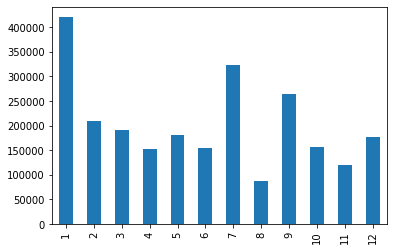

In [78]:
# look at the months in which data was created
roadseg['created'].dt.month.value_counts(sort=False).plot(kind='bar')

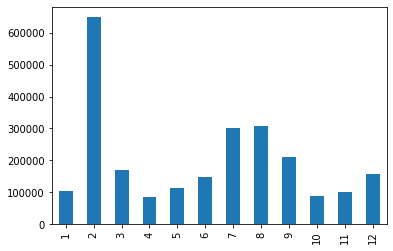

In [79]:
# look at the months in which data was created
roadseg['revised'].dt.month.value_counts(sort=False).plot(kind='bar')

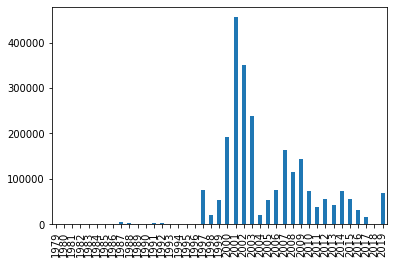

In [58]:
# look at the years in which data was created
roadseg['created'].dt.year.value_counts(sort=False).plot(kind='bar')

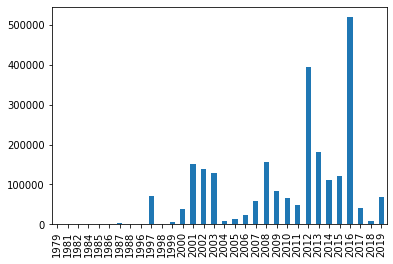

In [74]:
# look at the years in which data was created
roadseg['revised'].dt.year.value_counts(sort=False).plot(kind='bar')

In [69]:
roadseg['created'].dt.year.value_counts(sort=False)

1979       102
1980       107
1981       855
1982       388
1983        73
1984       252
1985       212
1986      1290
1987      5539
1988      2009
1989       609
1990        74
1991      3543
1992      2582
1993       483
1994        40
1995         1
1996      1670
1997     75745
1998     20595
1999     54436
2000    191125
2001    455813
2002    349674
2003    238333
2004     21009
2005     54193
2006     76503
2007    162590
2008    116155
2009    144526
2010     73446
2011     37550
2012     56762
2013     41651
2014     72926
2015     54955
2016     32185
2017     16925
2018       453
2019     67930
Name: created, dtype: int64

In [66]:
roadseg.groupby('datasetnam')['created'].min()

datasetnam
Alberta                     2000-09-01
British Columbia            1979-07-01
Manitoba                    2000-07-01
New Brunswick               2019-09-26
Newfoundland and Labrador   2001-03-01
Northwest Territories       1999-07-01
Nova Scotia                 1986-01-01
Nunavut                     1982-01-01
Ontario                     1999-12-01
Prince Edward Island        2003-11-01
Québec                      1980-01-01
Saskatchewan                2000-08-01
Yukon Territory             1999-12-30
Name: created, dtype: datetime64[ns]

In [67]:
roadseg.groupby('datasetnam')['created'].max()

datasetnam
Alberta                     2017-02-15
British Columbia            2017-03-01
Manitoba                    2012-10-01
New Brunswick               2019-09-26
Newfoundland and Labrador   2012-09-01
Northwest Territories       2017-11-01
Nova Scotia                 2017-03-13
Nunavut                     2013-01-01
Ontario                     2016-04-19
Prince Edward Island        2018-12-01
Québec                      2016-02-01
Saskatchewan                2018-12-01
Yukon Territory             2018-05-02
Name: created, dtype: datetime64[ns]

In [64]:
roadseg['datasetnam'].value_counts()

Ontario                      656621
Québec                       440398
Alberta                      413349
Saskatchewan                 291003
British Columbia             263584
Nova Scotia                  111570
Manitoba                     110604
New Brunswick                 67930
Newfoundland and Labrador     44484
Prince Edward Island          18140
Northwest Territories          6793
Yukon Territory                6591
Nunavut                        4242
Name: datasetnam, dtype: int64

In [70]:
roadseg.groupby('datasetnam')['revised'].min()

datasetnam
Alberta                     2012-05-30
British Columbia            1979-07-01
Manitoba                    2000-07-01
New Brunswick               2019-09-27
Newfoundland and Labrador   2001-03-01
Northwest Territories       1999-07-01
Nova Scotia                 2002-06-23
Nunavut                     1982-01-01
Ontario                     1999-12-01
Prince Edward Island        2010-03-01
Québec                      2016-02-01
Saskatchewan                2000-08-01
Yukon Territory             1999-12-30
Name: revised, dtype: datetime64[ns]

In [71]:
roadseg.groupby('datasetnam')['revised'].max()

datasetnam
Alberta                     2017-02-15
British Columbia            2017-03-01
Manitoba                    2012-10-01
New Brunswick               2019-09-27
Newfoundland and Labrador   2012-09-01
Northwest Territories       2017-11-01
Nova Scotia                 2017-03-14
Nunavut                     2013-01-01
Ontario                     2016-04-21
Prince Edward Island        2018-12-01
Québec                      2016-02-01
Saskatchewan                2018-12-01
Yukon Territory             2018-05-02
Name: revised, dtype: datetime64[ns]

In [72]:
roadseg['created'].dt.is_month_start.value_counts()

True     1862760
False     572549
Name: created, dtype: int64